In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
toronto_roads = gpd.read_file("data/Centreline-toronto- 4326.geojson")

# Filter to only City of Toronto 
toronto_roads = toronto_roads[toronto_roads['JURISDICTION'] == 'CITY OF TORONTO']

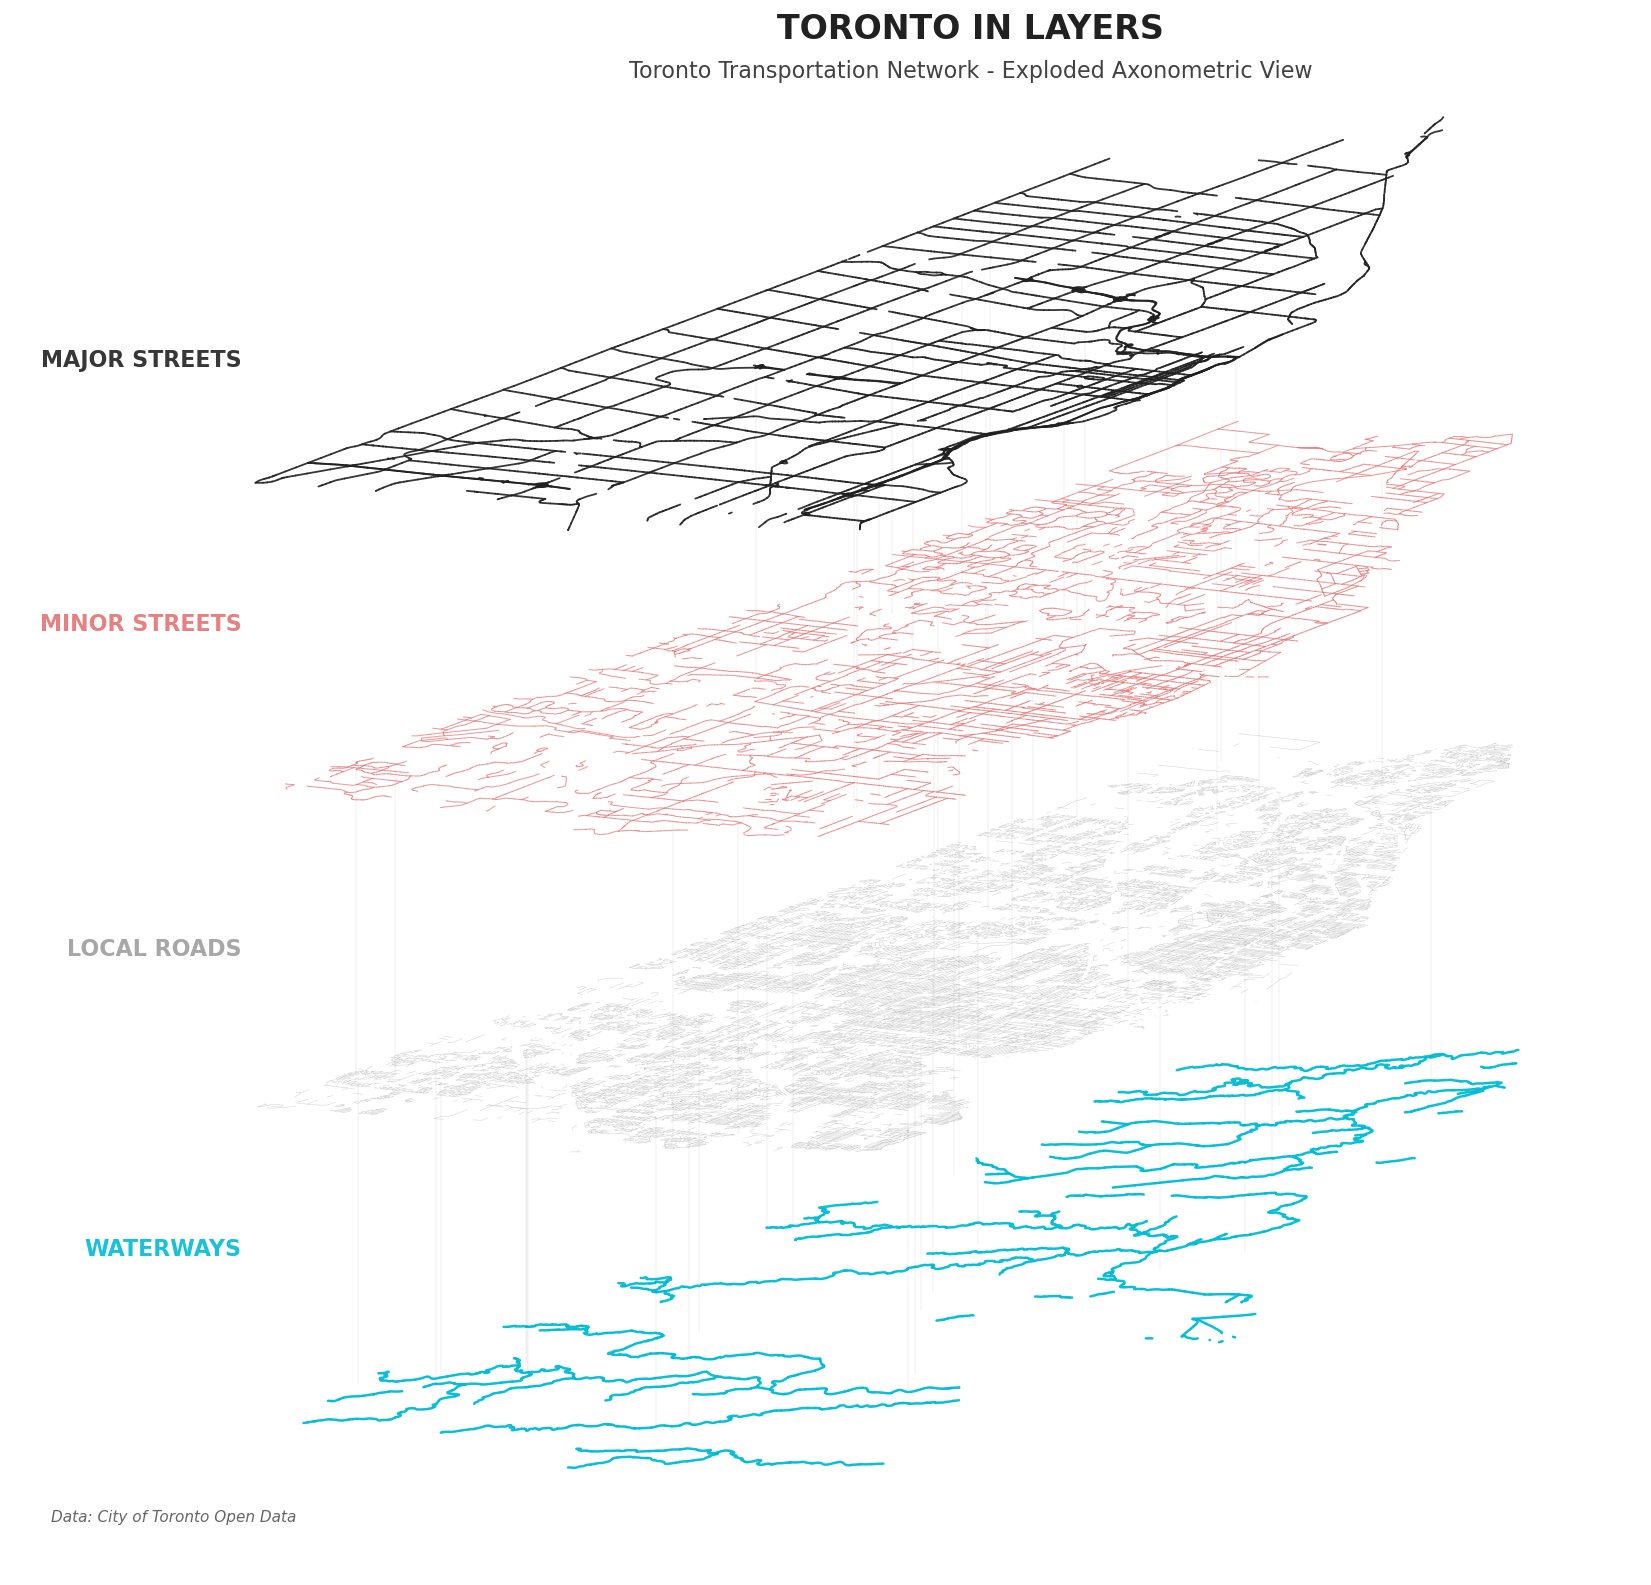

In [2]:
# Define layers to map
local_layer = ["Local"]
waterway_layer = ["River", "Ferry Route", "Creek/Tributary"]
minor_layer = ["Minor Arterial", "Collector", "Collector Ramp", "Minor Arterial Ramp"]
major_layer = ["Major Arterial", "Expressway", "Expressway Ramp", "Major Arterial Ramp"]

# Set up plot
fig, ax = plt.subplots(figsize=(24, 16))
ax.axis('off')

# Spacing between layers 
layer_spacing = 0.12

# Get bounds of the data
bounds = toronto_roads.total_bounds
width = bounds[2] - bounds[0]
height = bounds[3] - bounds[1]
center_x = (bounds[0] + bounds[2]) / 2
center_y = (bounds[1] + bounds[3]) / 2

# Angle layers
angle = 30
cos_angle = np.cos(np.radians(angle))
sin_angle = np.sin(np.radians(angle))

def transform_geometry(gdf, vertical_offset):
    """Apply isometric transformation with vertical offset"""
    transformed_coords = []
    
    for geom in gdf.geometry:
        if geom.geom_type == 'LineString':
            coords = np.array(geom.coords)
            lines_to_process = [coords]
        elif geom.geom_type == 'MultiLineString':
            lines_to_process = [np.array(line.coords) for line in geom.geoms]
        else:
            continue
        
        for coords in lines_to_process:
            x = coords[:, 0]
            y = coords[:, 1]
            
            x_iso = x - y * cos_angle
            y_iso = x * sin_angle * 0.5 + y * sin_angle * 0.5 + vertical_offset
            
            transformed_coords.append(np.column_stack([x_iso, y_iso]))
    
    return transformed_coords

# Layers with all style attributes
layers_config = [
    {
        'data': waterway_layer,
        'name': 'Waterways',
        'color': '#00BCD4',
        'linewidth': 1.8,
        'alpha': 0.95,
        'offset': 0
    },
    {
        'data': local_layer,
        'name': 'Local roads',
        'color': '#9E9E9E',
        'linewidth': 0.35,
        'alpha': 0.45,
        'offset': layer_spacing * 1
    },
    {
        'data': minor_layer,
        'name': 'Minor streets',
        'color': '#E57373',
        'linewidth': 0.75,
        'alpha': 0.7,
        'offset': layer_spacing * 2
    },
    {
        'data': major_layer,
        'name': 'Major streets',
        'color': '#212121',
        'linewidth': 1.3,
        'alpha': 0.9,
        'offset': layer_spacing * 3
    }
]

# Track all coordinates and layer positions
all_x_coords = []
all_y_coords = []
layer_y_positions = {}

# Plot each layer 
for i, layer_config in enumerate(layers_config):
    layer_data = toronto_roads[toronto_roads['FEATURE_CODE_DESC'].isin(layer_config['data'])]
    
    if len(layer_data) > 0:
        coords_list = transform_geometry(layer_data, layer_config['offset'])
        
        # Track the actual y-coordinates for this layer to position labels
        layer_y_coords = []
        
        # Plot each of the maps
        for coords in coords_list:
            ax.plot(coords[:, 0], coords[:, 1],
                   color=layer_config['color'],
                   linewidth=layer_config['linewidth'],
                   alpha=layer_config['alpha'],
                   solid_capstyle='round',
                   zorder=i)
            
            all_x_coords.extend(coords[:, 0])
            all_y_coords.extend(coords[:, 1])
            layer_y_coords.extend(coords[:, 1])
        
        # Store median y position for each layer 
        layer_y_positions[layer_config['name']] = np.median(layer_y_coords)
        
        # Connector lines between layers
        if i > 0:
            prev_offset = layers_config[i-1]['offset']
            curr_offset = layer_config['offset']
            
            # Lines through layers for location context
            sample_size = min(50, len(coords_list))
            sampled_indices = np.random.choice(len(coords_list), sample_size, replace=False)
            
            for idx in sampled_indices:
                if idx < len(coords_list):
                    coords = coords_list[idx]
                    if len(coords) > 3:
                        point_idx = len(coords) // 2
                        x_curr = coords[point_idx, 0]
                        y_curr = coords[point_idx, 1]
                        
                        y_prev = y_curr - (curr_offset - prev_offset)
                        ax.plot([x_curr, x_curr], [y_prev, y_curr],
                               'k-', linewidth=0.3, alpha=0.15, zorder=i-0.5)

# Layer labels on the same vertical level as the layers
if all_x_coords:
    label_x = min(all_x_coords) - width * 0.01
    
    for layer_config in layers_config:
        if layer_config['name'] in layer_y_positions:
            layer_y = layer_y_positions[layer_config['name']]
            
            # Text label for the layer to match its position and color
            ax.text(label_x, layer_y,
                   layer_config['name'].upper(),
                   fontsize=16,
                   va='center',
                   ha='right',
                   fontweight='bold',
                   fontfamily='sans-serif',
                   color=layer_config['color'],
                   alpha=0.9)

# Title at top center
if all_y_coords and all_x_coords:
    title_y = max(all_y_coords) + height * 0.1
    title_x = np.mean(all_x_coords)
    
    ax.text(title_x, title_y,
           'TORONTO IN LAYERS',
           fontsize=24,
           fontweight='bold',
           fontfamily='sans-serif',
           va='bottom',
           ha='center',
           color='#212121')
    
    ax.text(title_x, title_y - height * 0.02,
           'Toronto Transportation Network - Exploded Axonometric View',
           fontsize=16,
           fontfamily='sans-serif',
           va='top',
           ha='center',
           color='#424242')

# Data source 
if all_x_coords and all_y_coords:
    source_x = min(all_x_coords) - width * 0.15
    source_y = min(all_y_coords) - height * 0.08
    
    ax.text(source_x, source_y,
           'Data: City of Toronto Open Data',
           fontsize=11,
           va='bottom',
           ha='left',
           fontfamily='sans-serif',
           color='#666666',
           style='italic')
    
# Fit view around mapped data
if all_x_coords and all_y_coords:
    x_margin = width * 0.18
    y_margin = height * 0.15
    
    ax.set_xlim(min(all_x_coords) - x_margin, max(all_x_coords) + x_margin * 0.5)
    ax.set_ylim(min(all_y_coords) - y_margin, max(all_y_coords) + y_margin)

ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('toronto_roads_exploded.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
